### aim: Recreate Terhaar's fig x3.4.2 with various model simulations 

goal is to show that we accumulate anthropogenic carbon in the atlantic and not the pacific. 

### date: 

![Drag Racing](Terhaarx3.4.2.png)

In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


In [2]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [3]:
import numpy as np
from cmocean import cm
import cartopy as cp
import cartopy.crs as ccrs
import netCDF4 as nc
import matplotlib.pyplot as plt
import xarray as xr
import sys
sys.path.append('/gpfs/home/mep22dku/scratch/SOZONE')
#list of models
sys.path.append('/gpfs/home/mep22dku/scratch/SOZONE/UTILS')
import lom
import utils as ut

%matplotlib inline
import warnings
from datetime import datetime
warnings.filterwarnings('ignore')
import cartopy.feature as cfeature
from importlib import reload
import matplotlib.path as mpath
import glob
import pickle
import pandas as pd
import seawater
import time
plt.rcParams.update({'font.size': 12})
font = {'family' : 'normal',
'weight' : 'normal',
'size'   : 12}

plt.rc('font', **font)

### 1) Calculate C-anth from 2022 milestone GCB model, from GCB methodology:

    - GCB year 2002 for simulations B and C (C-B) visualise

In [4]:
## get the relevant years
yr = 2002
GCB_DW_C_f = f'/gpfs/data/greenocean/software/runs/TOM12_DW_GC01/ORCA2_1m_{yr}0101_*_ptrc_T.nc'
GCB_DW_B_f = f'/gpfs/data/greenocean/software/runs/TOM12_DW_GB01/ORCA2_1m_{yr}0101_*_ptrc_T.nc'

GCB_DW_C = xr.open_dataset(glob.glob(GCB_DW_C_f)[0])
GCB_DW_B = xr.open_dataset(glob.glob(GCB_DW_B_f)[0])

DG1_TJ_C_f = f'/gpfs/data/greenocean/software/runs/TOM12_TJ_DGC1/ORCA2_1m_{yr}0101_*_ptrc_T.nc'
DG1_TJ_B_f = f'/gpfs/data/greenocean/software/runs/TOM12_TJ_DGB1/ORCA2_1m_{yr}0101_*_ptrc_T.nc'

GCB_TJ_C = xr.open_dataset(glob.glob(DG1_TJ_C_f)[0])
GCB_TJ_B = xr.open_dataset(glob.glob(DG1_TJ_B_f)[0])

In [5]:
#tj broadcast a depth array of e3t_0 to get its dimensions to match the model output we are trying to calculate for. 
tmesh = xr.open_dataset('/gpfs/data/greenocean/software/resources/regrid/mesh_mask3_6.nc')
e3t_0 = tmesh.e3t_0
e3t_0_rn = e3t_0.rename({'t': 'time_counter','z': 'deptht'})
e3t_0_rn_b = np.zeros([12,31,149,182])

for i in range(0,12):
    e3t_0_rn_b[i,:,:,:] = e3t_0_rn.values
    
# savenam = 'test2.nc'
data_vars = {'e3t_0':(['time_counter', 'deptht', 'y', 'x'], e3t_0_rn_b,
{'units': 'm',
'long_name':'meters, t grid'}),
}
# define coordinates
coords = {'time_counter': (['time_counter'], GCB_DW_C.time_counter),
'y': (['y'], tmesh.y.values),
'x': (['x'], tmesh.x.values),
'deptht': (['deptht'], GCB_DW_C.deptht.values)}
# define global attributes
attrs = {'made in':'SOZONE/GRO2_FORCING_EXPERIMENT/anthCarbonAccumulation_figx3.4.2.ipynb',
'desc': 'a broadcasted e3t_0 into 12 months, for multiplication'
}
ds = xr.Dataset(data_vars=data_vars,
coords=coords,
attrs=attrs)


Text(0.5, 1.0, 'Anth DIC accumulation to year 2002, \n calculated as DW_GCB_simC - DW_GCB_simB, year 2002 \n ~problematic~ Pacific accumulation visible')

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


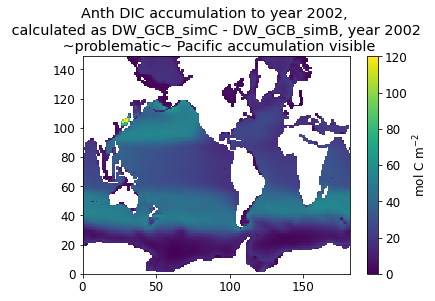

In [6]:
DIC_DW_C_molm2 = GCB_DW_C.DIC.load() * ds.e3t_0.load() * 1000 
DIC_DW_B_molm2 = GCB_DW_B.DIC.load() * ds.e3t_0.load() * 1000 
#multiplying by 1000 goes from mol/L > mol/m3, multiplying by ds.e3t_0 should give you  mol/m2

test = False
if test:
    #this checks that it did the thing and all the dimensions make sense
    print(GCB_DW_C.DIC[0,0:4,50,100].values)
    print(ds.e3t_0[0,0:4,50,100].values)
    print(GCB_DW_C.DIC[0,0:4,50,100].values * ds.e3t_0[0,0:4,50,100].values)
    print(DIC_DW_C_molm2[0,0:4,50,100].values)
    
    
anth_DIC_molm2 = DIC_DW_C_molm2-DIC_DW_B_molm2
anth_DIC_molm2 = anth_DIC_molm2[:,0:27,:,:] #to 3000 m depth approximately, last cell has depth 3257
anth_DIC_molm2_2d = np.nanmean(np.nansum(anth_DIC_molm2, axis = 1), axis = 0) #yearly mean, summed across depths

anth_DIC_molm2_2d[anth_DIC_molm2_2d == 0] = np.nan
w = plt.pcolormesh(anth_DIC_molm2_2d, vmin = 0, vmax = 120)
plt.colorbar(w, label = 'mol C m$^{-2}$', )
plt.title('Anth DIC accumulation to year 2002, \n calculated as DW_GCB_simC - DW_GCB_simB, year 2002 \n ~problematic~ Pacific accumulation visible')

Text(0.5, 1.0, 'Anth DIC accumulation to year 2002, \n calculated as TJ_GCB_simC - TJ_GCB_simB, year 2002 \n ~problematic~ Pacific accumulation WENT AWAY')

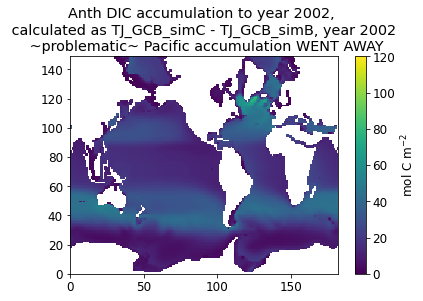

In [7]:
DIC_TJ_C_molm2 = GCB_TJ_C.DIC.load() * ds.e3t_0.load() * 1000 
DIC_TJ_B_molm2 = GCB_TJ_B.DIC.load() * ds.e3t_0.load() * 1000 
#multiplying by 1000 goes from mol/L > mol/m3, multiplying by ds.e3t_0 should give you  mol/m2

test = False
if test:
    #this checks that it did the thing and all the dimensions make sense
    print(GCB_TJ_C.DIC[0,0:4,50,100].values)
    print(ds.e3t_0[0,0:4,50,100].values)
    print(GCB_TJ_C.DIC[0,0:4,50,100].values * ds.e3t_0[0,0:4,50,100].values)
    print(DIC_TJ_C_molm2[0,0:4,50,100].values)
    
    
anth_DIC_molm2 = DIC_TJ_C_molm2-DIC_TJ_B_molm2
anth_DIC_molm2 = anth_DIC_molm2[:,0:27,:,:] #to 3000 m depth approximately, last cell has depth 3257
anth_DIC_molm2_2d = np.nanmean(np.nansum(anth_DIC_molm2, axis = 1), axis = 0) #yearly mean, summed across depths

anth_DIC_molm2_2d[anth_DIC_molm2_2d == 0] = np.nan
w = plt.pcolormesh(anth_DIC_molm2_2d, vmin = 0, vmax = 120)
plt.colorbar(w, label = 'mol C m$^{-2}$', )
plt.title('Anth DIC accumulation to year 2002, \n calculated as TJ_GCB_simC - TJ_GCB_simB, year 2002 \n ~problematic~ Pacific accumulation WENT AWAY')



### 2) Calculate C-anth accumulation, roughly, 1955-1960 -2000-2005, for an array of new models

different methodology, we only have simulation "A" for these, dynamic climate and rising CO2

so I will calculate mean C molm2 for years [1955-1960] and years [2000-2005] and subtract them. This calculation isn't the same as the one above but it will give me  an idea of the spatial distribution. 



extract relevant metrics in /gpfs/home/mep22dku/scratch/SOZONE/GRO2_FORCING_EXPERIMENT/runner.py

In [8]:
tdir = '/gpfs/home/mep22dku/scratch/SOZONE/GRO2_FORCING_EXPERIMENT/extracted/'

ds_GS00 = xr.open_dataset(f'{tdir}anthdic_and_aux_TOM12_RW_GS00.nc')
ds_GRO2 = xr.open_dataset(f'{tdir}anthdic_and_aux_TOM12_RW_GRO2.nc')
ds_GERA = xr.open_dataset(f'{tdir}anthdic_and_aux_TOM12_RW_GERA.nc')
ds_GSER = xr.open_dataset(f'{tdir}anthdic_and_aux_TOM12_RW_GSER.nc')
ds_1ASA = xr.open_dataset(f'{tdir}anthdic_and_aux_TOM12_TJ_1ASA.nc')
ds_DGA1 = xr.open_dataset(f'{tdir}anthdic_and_aux_TOM12_TJ_DGA1.nc')

Text(0.5, 0.92, 'Anth DIC accumulation to year 2002, calculated as [DIC 2000-2005] - [DIC 1955-1960], full watercolumn')

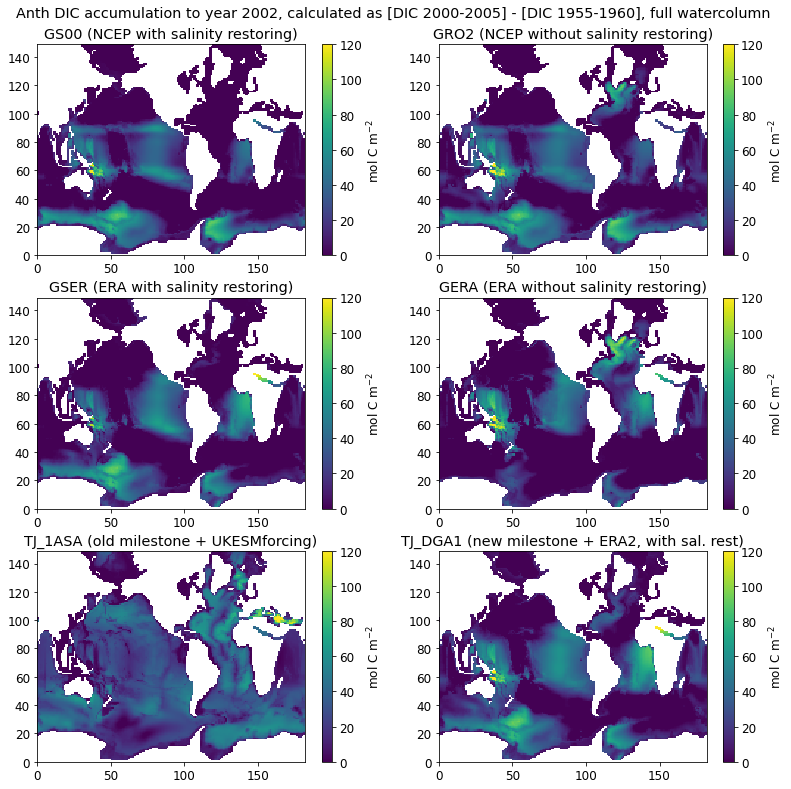

In [9]:
fact = 1.1
fig, axs = plt.subplots(3,2, figsize=(12*fact, 12*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

anthdics = [ds_GS00.anthdic_molm2, 
            ds_GRO2.anthdic_molm2, 
            ds_GSER.anthdic_molm2, 
            ds_GERA.anthdic_molm2, 
           ds_1ASA.anthdic_molm2, 
            ds_DGA1.anthdic_molm2]

titles = ['GS00 (NCEP with salinity restoring)',
          'GRO2 (NCEP without salinity restoring)',
          'GSER (ERA with salinity restoring)',
          'GERA (ERA without salinity restoring)',
          'TJ_1ASA (old milestone + UKESMforcing)',
          'TJ_DGA1 (new milestone + ERA2, with sal. rest)']

for i in range(0,len(anthdics)):
    w = axs[i].pcolormesh(anthdics[i], vmin = 0, vmax = 120)
    plt.colorbar(w, label = 'mol C m$^{-2}$', ax = axs[i] )
    axs[i].set_title(titles[i])

plt.suptitle('Anth DIC accumulation to year 2002, calculated as [DIC 2000-2005] - [DIC 1955-1960], full watercolumn', y = 0.92)



Text(0.5, 0.92, 'Anth DIC accumulation to year 2002, calculated as [DIC 2000-2005] - [DIC 1955-1960], to around 3000m')

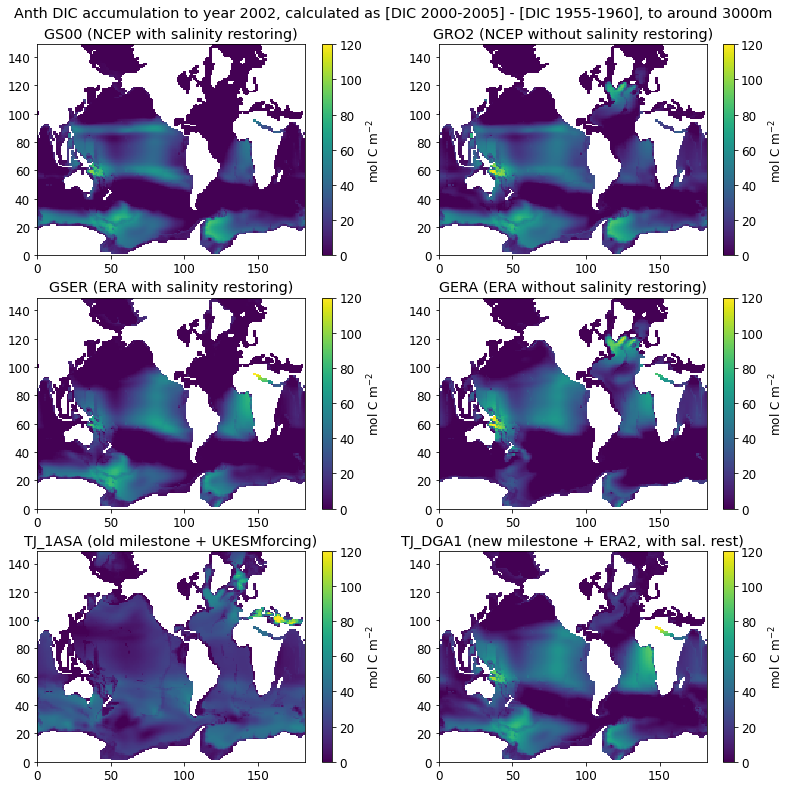

In [10]:
fact = 1.1
fig, axs = plt.subplots(3,2, figsize=(12*fact, 12*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

anthdics = [ds_GS00.anthdic_molm2_3000, 
            ds_GRO2.anthdic_molm2_3000, 
            ds_GSER.anthdic_molm2_3000, 
            ds_GERA.anthdic_molm2_3000, 
           ds_1ASA.anthdic_molm2_3000, 
            ds_DGA1.anthdic_molm2_3000]

titles = ['GS00 (NCEP with salinity restoring)',
          'GRO2 (NCEP without salinity restoring)',
          'GSER (ERA with salinity restoring)',
          'GERA (ERA without salinity restoring)',
          'TJ_1ASA (old milestone + UKESMforcing)',
          'TJ_DGA1 (new milestone + ERA2, with sal. rest)']

for i in range(0,len(anthdics)):
    tanth = anthdics[i].values
    tanth[tanth == 0] = np.nan
    w = axs[i].pcolormesh(tanth, vmin = 0, vmax = 120)
    plt.colorbar(w, label = 'mol C m$^{-2}$', ax = axs[i] )
    axs[i].set_title(titles[i])

plt.suptitle('Anth DIC accumulation to year 2002, calculated as [DIC 2000-2005] - [DIC 1955-1960], to around 3000m', y = 0.92)



In [ ]:
tdir = '/gpfs/home/mep22dku/scratch/SOZONE/GRO2_FORCING_EXPERIMENT/extracted/'

ds_GS00 = xr.open_dataset(f'{tdir}anthdic_and_aux_TOM12_RW_GS00.nc')
ds_GRO2 = xr.open_dataset(f'{tdir}anthdic_and_aux_TOM12_RW_GRO2.nc')
ds_GERA = xr.open_dataset(f'{tdir}anthdic_and_aux_TOM12_RW_GERA.nc')
ds_GSER = xr.open_dataset(f'{tdir}anthdic_and_aux_TOM12_RW_GSER.nc')
ds_1ASA = xr.open_dataset(f'{tdir}anthdic_and_aux_TOM12_TJ_1ASA.nc')
ds_DGA1 = xr.open_dataset(f'{tdir}anthdic_and_aux_TOM12_TJ_DGA1.nc')

In [33]:
ds_1ASA

<xarray.Dataset>
Dimensions:             (x: 182, y: 149)
Coordinates:
    nav_lat             (y, x) float32 ...
    nav_lon             (y, x) float32 ...
Dimensions without coordinates: x, y
Data variables:
    sos                 (y, x) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    mldr10_1            (y, x) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    somxl030            (y, x) float32 nan nan nan nan nan ... nan nan nan nan
    Cflx                (y, x) float32 ...
    anthdic_molm2       (y, x) float64 nan nan nan nan nan ... nan nan nan nan
    anthdic_molm2_3000  (y, x) float64 nan nan nan nan nan ... nan nan nan nan
Attributes:
    made in:  SOZONE/GRO2_FORCING_EXPERIMENT/anthCarbonAccumulation_figx3.4.2...
    desc:     yearly medusa files, saving only variables of interest

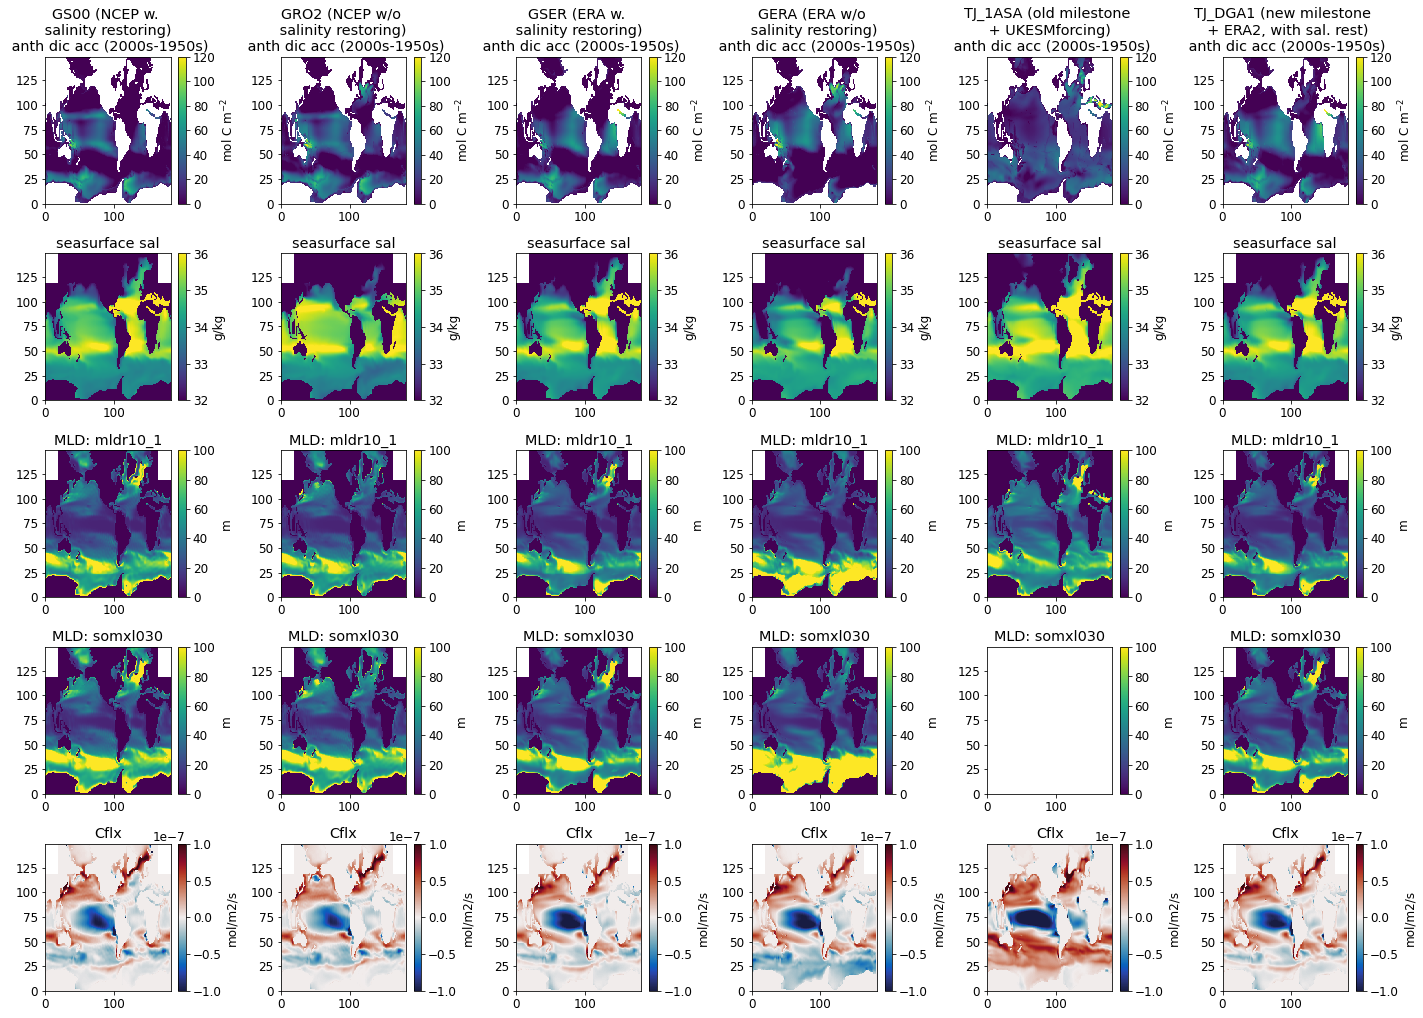

In [48]:
fact = 1.1
fig, axs = plt.subplots(5,6, figsize=(18*fact, 13*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

# anthdics_3000 = [ds_GS00.anthdic_molm2_3000, 
#             ds_GRO2.anthdic_molm2_3000, 
#             ds_GSER.anthdic_molm2_3000, 
#             ds_GERA.anthdic_molm2_3000, \
#            ds_1ASA.anthdic_molm2_3000, 
#             ds_DGA1.anthdic_molm2_3000]

anthdics_3000 = [ds_GS00, 
            ds_GRO2, 
            ds_GSER, 
            ds_GERA, \
           ds_1ASA, 
            ds_DGA1]


# aux_dsets = [ds_GS00, ds_GRO2, ds_GRO2]
titles = ['GS00 (NCEP w. \n salinity restoring)',
          'GRO2 (NCEP w/o \n salinity restoring)',
          'GSER (ERA w. \n salinity restoring)',
          'GERA (ERA w/o \n salinity restoring)',
          'TJ_1ASA (old milestone \n + UKESMforcing)',
          'TJ_DGA1 (new milestone \n  + ERA2, with sal. rest)']

for i in range(0,len(anthdics_3000)):
    w = axs[i].pcolormesh(anthdics_3000[i].anthdic_molm2_3000, vmin = 0, vmax = 120)
    plt.colorbar(w, label = 'mol C m$^{-2}$', ax = axs[i] )
    axs[i].set_title(f'{titles[i]} \n anth dic acc (2000s-1950s)')
    
ind = 6; tvmin = 32; tvmax = 36; tlab = 'g/kg'; quant = 'seasurface sal'
for i in range(0,len(anthdics_3000)):
    w = axs[ind+i].pcolormesh(anthdics_3000[i].sos, vmin = tvmin, vmax = tvmax)
    plt.colorbar(w, label = tlab, ax = axs[ind+i] )
    axs[ind+i].set_title(f'{quant}')
    
ind = 12; tvmin = 0; tvmax = 100; tlab = 'm'; quant = 'MLD: mldr10_1'
for i in range(0,len(anthdics_3000)):
    w = axs[ind+i].pcolormesh(anthdics_3000[i].mldr10_1, vmin = tvmin, vmax = tvmax)
    plt.colorbar(w, label = tlab, ax = axs[ind+i] )
    axs[ind+i].set_title(f'{quant}')
    
ind = 18; tvmin = 0; tvmax = 100; tlab = 'm'; quant = 'MLD: somxl030'
for i in range(0,len(anthdics_3000)):
    w = axs[ind+i].pcolormesh(anthdics_3000[i].somxl030, vmin = tvmin, vmax = tvmax)
    plt.colorbar(w, label = tlab, ax = axs[ind+i] )
    axs[ind+i].set_title(f'{quant}')
    
ind = 24; tvmin = -1e-7; tvmax = -1 * tvmin; tlab = 'mol/m2/s'; quant = 'Cflx'
for i in range(0,len(anthdics_3000)):
    w = axs[ind+i].pcolormesh(anthdics_3000[i].Cflx, vmin = tvmin, vmax = tvmax, cmap = cm.balance)
    plt.colorbar(w, label = tlab, ax = axs[ind+i] )
    axs[ind+i].set_title(f'{quant}')
#plt.suptitle('Anth DIC accumulation to year 2002, calculated as [DIC 2000-2005] - [DIC 1955-1960]', y = 0.92)

plt.tight_layout()
fig.savefig('./summary_comparison_auxfiles.jpg')

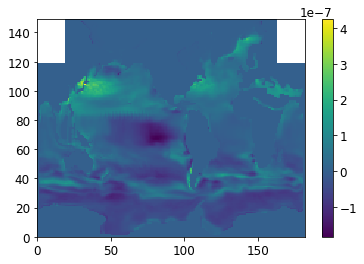

In [44]:
w = xr.open_dataset('/gpfs/data/greenocean/software/runs/TOM12_TJ_DGA1/ORCA2_1m_20190101_20191231_diad_T.nc')

q = plt.pcolormesh(w.Cflx[0,:,:])
plt.colorbar(q)

In [ ]:
# mldr10_1, somxl030, sos > gridT
#  Cflx >diad_T 

GS00_55_gridT = xr.open_mfdataset(make_yearlist(1955, 2005, 'grid_T', 'TOM12_RW_GS00'))
GS00_55_diadT = xr.open_mfdataset(make_yearlist(1955, 2005, 'diad_T', 'TOM12_RW_GS00'))


def get 

In [ ]:
GS00_55_sos = GS00_55_gridT.sos.groupby('time_counter.year').mean().mean(dim = 'year')
GS00_55_mldr10_1 = GS00_55_gridT.mldr10_1.groupby('time_counter.year').mean().mean(dim = 'year')
GS00_55_somxl030 = GS00_55_gridT.somxl030.groupby('time_counter.year').mean().mean(dim = 'year')
GS00_55_Cflx = GS00_55_diadT.Cflx.groupby('time_counter.year').mean().mean(dim = 'year')

In [ ]:
GS00_55_sos

In [ ]:
RW_GS00_ds = get_relevant_metrics('TOM12_RW_GS00')

In [ ]:
RW_GS00_ds